<a href="https://colab.research.google.com/github/icculp/holbertonschool-machine_learning/blob/main/reinforcement_learning/0x01-deep_q_learning/train_and_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars
!pip install keras-rl2
!pip install gym
!pip install gym[atari]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assau

In [2]:
import rl
import keras as K
import gym
from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

In [3]:
env = gym.make('Breakout-v0')   # 'Breakout-ram-v0')  # Breakout-v0')
env.reset()
#height, width, channels = 
#print(env.observation_space.shape)
shp = env.observation_space.shape
actions = env.action_space.n
print(actions)

4


In [4]:
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = K.layers.Input((actions,) + shp) #  (84, 84, 4,)) #  # shape=(1, 1, 128)) # (84, 84, 4,))

    # Convolutions on the frames on the screen
    layer1 = K.layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = K.layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = K.layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = K.layers.Flatten()(layer3)

    layer5 = K.layers.Dense(512, activation="relu")(layer4)
    action = K.layers.Dense(actions, activation="linear")(layer5)

    return K.Model(inputs=inputs, outputs=action)

In [5]:
def build_agent(model, actions):
    memory = SequentialMemory(limit=1000, window_length=actions)
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1,
                                  value_test=.05, nb_steps=1000)
    agent = DQNAgent(model, policy=policy, test_policy=None, enable_double_dqn=True, enable_dueling_network=False,
                     dueling_type='avg', nb_actions=actions, memory=memory)
    return agent

In [6]:
'''import tensorflow as tf
session = K.backend.get_session()
init = tf.compat.v1.global_variables_initializer()
session.run(init)'''


model = create_q_model()
# model_target = create_q_model()

'''init = tf.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)'''

'init = tf.global_variables_initializer()\nsess = tf.compat.v1.Session()\nsess.run(init)'

In [7]:
dqn = build_agent(model, actions)
dqn.compile(K.optimizers.Adam(lr=0.00025), metrics=['mae'])
# callbacks = [FileLogger('log', interval=1000)]
dqn.fit(env, nb_steps=1000,
        visualize=False) 
#,
#        verbose=2) 
#,
#callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training for 1000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


  997/10000 [=>............................] - ETA: 2:04 - reward: 0.0070done, took 43.024 seconds


In [8]:
dqn.save_weights('policy.h5', overwrite=True)

In [9]:
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# import os
# os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 1s (1,271 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 71kB 9.9MB/s 


In [10]:
dqn.test(env, nb_episodes=3, visualize=True)

Testing for 3 episodes ...
Episode 1: reward: 0.000, steps: 10000
Episode 2: reward: 0.000, steps: 10000
Episode 3: reward: 0.000, steps: 10000


test episode: 0 R: 0.0
test episode: 1 R: 2.0
test episode: 2 R: 0.0


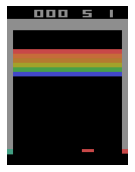

In [11]:
# env.render()

frames = []
for i in range(3):
    obs = env.reset()
    done = False
    R = 0
    t = 0
    while not done and t < 200:
        frames.append(env.render(mode = 'rgb_array'))
        obs, r, done, _ = env.step(env.action_space.sample())
        R += r
        t += 1
    print('test episode:', i, 'R:', R)
 
env.render()

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

In [12]:
# !export DISPLAY=localhost:0.0 

In [13]:
#!apt-get install -y xvfb x11-utils
##!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
#!pip install pyvirtualdisplay


In [14]:
# !pip freeze

In [15]:
#import pyvirtualdisplay


#_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
#                                    size=(1400, 900))
#_ = _display.start()